<a href="https://colab.research.google.com/github/SamruddhiMetkar/stock-price-forecasting/blob/main/final_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 4.1 MB/s eta 0:00:00


100%|██████████| 252/252 [06:05<00:00,  1.45s/it]


worst baseline HMM 2.026084083090855
current baseline HMM 1.9931715748057708
Running time of HMM: 365.65849256515503
worst baseline KF 2.026084083090855
current baseline KF 1.9661323496348688
Running time of KF: 0.0016841888427734375


100%|██████████| 252/252 [06:08<00:00,  1.46s/it]


worst baseline HMM 2.026084083090855
current baseline HMM 1.9976187708405726
Running time of HMM: 368.56691813468933
Mean Absolute Percentage Error (KF) in log scale: 0.33872678965847763
Mean Absolute Percentage Error (HMM) in log scale: 0.3443339381687143
Mean SE (HMM) in log scale: 0.0008541115791004633
Mean SE (KF) in log scale: 0.0008074767135454761
RMSE (KF) in log scale: 0.028416134739712155
RMSE (HMM) in log scale: 0.029225187409158956


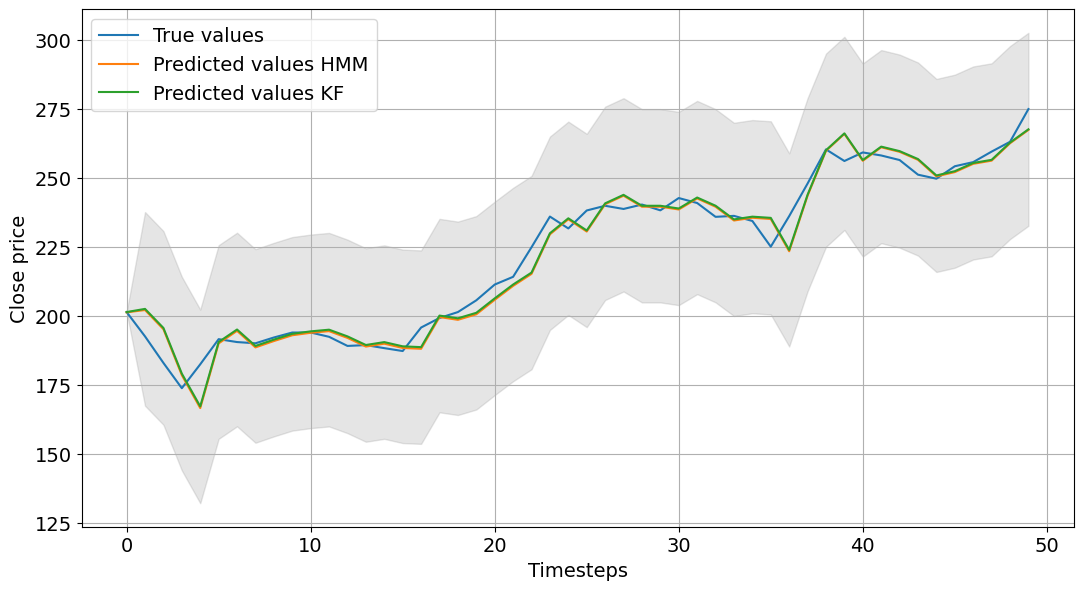

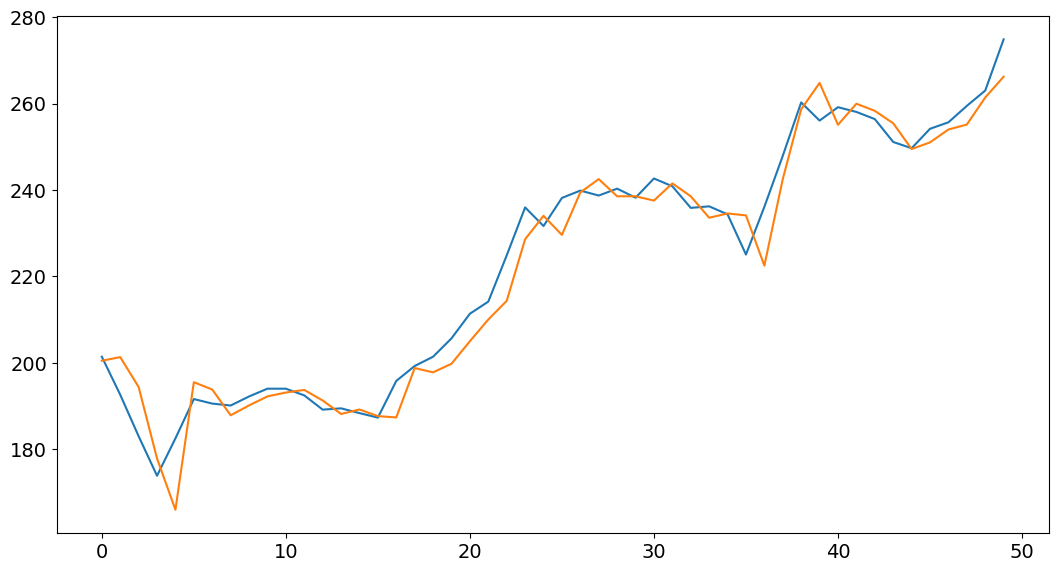

In [ ]:
# -*- coding: utf-8 -*-
"""Hidden Markov Model

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iMQgMTNYtyw5_rppw4pUG3-qTqkk4z3C
"""

!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import itertools
from tqdm import tqdm
import time
plt.rcParams.update({'font.size': 14})

## load the data and split them to train and test
data = pd.read_csv("/content/ADANIPOWER.NS.csv")

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
data = data.values[-555:,:-2]

# We train on 2018 data and we consider only open and high price
train = data[:-252, 1:5]

# We test on 2019 data
test = data[-252:, 1:5]

# We train on 2018 data and we consider only open and high price
train_X = train[:,0]
train_Y = train[:,3]
# We test on 2019 data
test_X = test[:,0]
test_Y = test[:,3]


def transform_train_data(data):
        # frac_change = (close - open) / open
        #These lines compute the fractional changes, highs, and lows based on the input data. Specifically,
        #frac_change computes the fractional change in closing price, frac_high computes the fractional change in high price, and frac_low computes the fractional change in low price.
        frac_change = (data[:,3] - data[:,0]) / data[:,0]

        # frac_high = (high - open) / open
        frac_high = (data[:,1] - data[:,0]) / data[:,0]

        # frac_low = (open - low) / open
        frac_low = (data[:,0] - data[:,2]) / data[:,0]

        return np.vstack((frac_change, frac_high, frac_low)).T

## train the model
class HMM_model():
    def __init__(self, n_components):
      #This line initializes the GaussianHMM model with the specified number of components (n_components).
        self.model = GaussianHMM(n_components=n_components, algorithm='map', covariance_type='diag')

    def transform_data(self, data):
        # frac_change = (close - open) / open
        frac_change = (data[:,3] - data[:,0]) / data[:,0]

        # frac_high = (high - open) / open
        frac_high = (data[:,1] - data[:,0]) / data[:,0]

        # frac_low = (open - low) / open
        frac_low = (data[:,0] - data[:,2]) / data[:,0]

        return np.vstack((frac_change, frac_high, frac_low)).T

    def fit(self, train_data, sequence_len=-1):
        train_preprocessed = self.transform_data(train_data)
        #This line preprocesses the training data using the transform_data method defined earlier.
        if sequence_len != -1:
            lengths = divide_to_seq(train_preprocessed, sequence_len)
            self.model.fit(train_preprocessed, lengths)
        else:
            self.model.fit(train_preprocessed)

    def compute_predecessors(self, train, test, test_case_indice, latency):
        if test_case_indice == 0:
            predecessors = train[-latency:]
            return predecessors
        elif test_case_indice < latency:
            predecessors = np.concatenate((train[- latency + test_case_indice:], test[:test_case_indice]), axis=0)
            return predecessors
        elif test_case_indice >= latency:
            predecessors = test[test_case_indice - latency : test_case_indice]
            return predecessors

    def predict_for_one(self, predecessors, combinations):
        scores = []
        # compute the scores using the MAP
        for elt in combinations:
            elt_to_score = np.concatenate((predecessors, elt.reshape(-1,3)), axis=0)
            score = self.model.score(elt_to_score)
            scores.append(score)
        # returning the argmax
        scores = np.array(scores)
        return combinations[np.argmax(scores)]

    def predict(self, train_data, test_data, latency):
        # span the possible values
        frac_change_space = np.linspace(-0.1, 0.1, 50)
        frac_high_space = np.linspace(0, 0.1, 10)
        frac_low_space = np.linspace(0, 0.1, 10)

        # all possible combinations
        combinations = np.array(list(itertools.product(*[frac_change_space, frac_high_space, frac_low_space])))

        # transform the old train and test to get the new features
        train_data_preprocessed = self.transform_data(train_data)
        test_data_preprocessed = self.transform_data(test_data)

        predictions = []
        l = len(test_data_preprocessed)
        for i in tqdm(range(l)):
            predecessors = self.compute_predecessors(train_data_preprocessed, test_data_preprocessed, i, latency=latency)
            pred = self.predict_for_one(predecessors, combinations)
            predictions.append(pred)

        predictions = np.vstack(predictions)

        return predictions

def divide_to_seq(data, len_):
    n = int(len(data)/len_)
    lengths = []

    for i in range(n):
        elt = data[i*len_: i*len_+len_]
        lengths.append(len(elt))

    if n*len_ != len(data):
        elt = data[n*len_:]
        lengths.append(len(elt))

    return lengths

## test the model
def test_model_make_plots(train, test, n_components=5, latency=10, sequence_len=-1):
    since = time.time()

    model = HMM_model(n_components)
    model.fit(train, sequence_len)
    predictions = model.predict(train, test, latency=latency)

    time_elapsed = time.time() - since

    predicted_close = predictions[:,0] * test[:, 0] + test[:, 0]

    plt.figure(figsize=(6.4*2, 4.8*1.4))
    plt.plot(np.arange(len(test[:50])), test[:50, 3])
    plt.plot(np.arange(len(predicted_close[:50])), predicted_close[:50])
    '''plt.legend(['True values', 'Predicted values'])
    plt.xlabel('Timesteps')
    plt.ylabel('Close price')
    plt.grid()'''

    # we define the worst baseline as the opening price, if you can't do better you are better off predicting this price
    print('worst baseline HMM', np.mean(np.abs((test[:, 3] - test[:, 0]) / test[:, 3])) * 100)
    print('current baseline HMM', np.mean(np.abs((test[:, 3] - predicted_close) / test[:, 3])) * 100)
    print('Running time of HMM:', time_elapsed)
    return predictions
    print('Predictions:', predicted_close)


def pre_filtering(x, a, b, c, f):

  T = len(x)

  mu = np.zeros(shape=(T))
  p = np.zeros(shape=(T))
  k = np.zeros(shape=(T))
  p[0] = 10000
  mu[0] = x[0]

  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]
    p[t] = (b**2) * p[t-1] + c**2
    k[t] = p[t] / (p[t] + f**2)

  return mu, p, k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, p, k = pre_filtering(x, a, b, c, f)

  mu_filt = np.zeros(shape=(T))
  p_filt = np.zeros(shape=(T))

  for t in range(T):
    mu_filt[t] = mu[t] + k[t]*(y[t] - mu[t])
    p_filt[t] = (f**2) * k[t]

  return mu_filt, p_filt

def initialize_params(x, y):
    T = len(y)

    x_t = x[1:]
    x_t_1 = x[:-1]

    f_2 = ((y - x)**2).sum() / len(y)
    b = ((T-1)*(x_t * x_t_1).sum() - x_t.sum() * x_t_1.sum())/((T-1)*((x_t_1**2).sum()) - x_t_1.sum()**2)
    a = (x_t - b*x_t_1).sum() / (T-1)
    c_2 = ((x_t - a - b*x_t_1)**2).sum() / (T-1)

    return a, b, c_2, f_2

test_model_make_plots(train, test, latency=10, sequence_len = -1)

x_train = train_Y
y_train = train_X
x_test = test_Y
y_test = test_X

since_kf = time.time()

a, b, c_2, f_2 = initialize_params(x_train, y_train)

mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

time_elapsed_kf = time.time() - since_kf

plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values HMM', 'Predicted values KF'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()

print('worst baseline KF', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
print('current baseline KF', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)
print('Running time of KF:', time_elapsed_kf)
# # Convert x_test to a NumPy array with float64 data type
# x_test_np = np.array(x_test, dtype=np.float64)

# # Calculate the accuracy metrics in log scale
# log_true_values = np.log(x_test_np)
# log_predicted_values = np.log(mu_fore)

# log_mae = np.mean(np.abs(log_true_values - log_predicted_values))
# log_mse = np.mean((log_true_values - log_predicted_values)**2)
# log_rmse = np.sqrt(log_mse)
# log_mape = np.mean(np.abs((log_true_values - log_predicted_values) / log_true_values)) * 100

# print(log_mae,log_mse,log_rmse,log_mape)


# def test_model_make_plots(train, test, n_components=5, latency=10, sequence_len=-1):
#     since = time.time()

#     model = HMM_model(n_components)
#     model.fit(train, sequence_len)
#     predictions = model.predict(train, test, latency=latency)

#     time_elapsed = time.time() - since

#     predicted_close = predictions[:,0] * test[:, 0] + test[:, 0]

#     plt.figure(figsize=(6.4*2, 4.8*1.4))
#     plt.plot(np.arange(len(test[:50])), test[:50, 3])
#     plt.plot(np.arange(len(predicted_close[:50])), predicted_close[:50])

#     # we define the worst baseline as the opening price, if you can't do better you are better off predicting this price
#     print('worst baseline HMM', np.mean(np.abs((test[:, 3] - test[:, 0]) / test[:, 3])) * 100)
#     print('current baseline HMM', np.mean(np.abs((test[:, 3] - predicted_close) / test[:, 3])) * 100)
#     print('Running time of HMM:', time_elapsed)

#     return predictions  # return the predictions



#Call the function to get predictions
predictions = test_model_make_plots(train, test, latency=10, sequence_len=-1)

predicted_close = predictions[:,0] * test[:, 0] + test[:, 0]

# Convert x_test to a NumPy array with float64 data type
x_test_np = np.array(x_test, dtype=np.float64)
predicted_close_np = np.array(predicted_close, dtype=np.float64)
# Calculate the natural logarithm of the test data and predicted values
log_true_values = np.log(x_test_np)
log_predicted_values_kf = np.log(mu_fore)
#log_predicted_values_hmm = np.log(predicted_close)
log_predicted_values_hmm = np.log(predicted_close_np)

# Calculate the absolute percentage error for KF predictions in log scale
abs_percentage_error_kf = np.abs((log_true_values - log_predicted_values_kf) / log_true_values) * 100

# Calculate the absolute percentage error for HMM predictions in log scale
abs_percentage_error_hmm = np.abs((log_true_values - log_predicted_values_hmm) / log_true_values) * 100

# Calculate the mean absolute percentage error for KF predictions in log scale
mean_abs_percentage_error_kf = np.mean(abs_percentage_error_kf)

# Calculate the mean absolute percentage error for HMM predictions in log scale
mean_abs_percentage_error_hmm = np.mean(abs_percentage_error_hmm)


log_mse_kf = np.mean((log_true_values - log_predicted_values_kf)**2)
log_mse_hmm = np.mean((log_true_values - log_predicted_values_hmm)**2)

log_rmse_hmm = np.sqrt(log_mse_hmm)
log_rmse_kf = np.sqrt(log_mse_kf)

print('Mean Absolute Percentage Error (KF) in log scale:', mean_abs_percentage_error_kf)
print('Mean Absolute Percentage Error (HMM) in log scale:', mean_abs_percentage_error_hmm)
print('Mean SE (HMM) in log scale:',log_mse_hmm )

print('Mean SE (KF) in log scale:', log_mse_kf)
print('RMSE (KF) in log scale:', log_rmse_kf)
print('RMSE (HMM) in log scale:',log_rmse_hmm )

# # Calculate the absolute percentage error for KF predictions in log scale
# abs_percentage_error_kf = np.abs((x_test - mu_fore) / x_test) * 100

# # Calculate the absolute percentage error for HMM predictions in log scale
# abs_percentage_error_hmm = np.abs((test[:, 3] - predicted_close) / test[:, 3]) * 100

# # Calculate the mean absolute percentage error for KF predictions in log scale
# mean_abs_percentage_error_kf = np.mean(abs_percentage_error_kf)

# # Calculate the mean absolute percentage error for HMM predictions in log scale
# mean_abs_percentage_error_hmm = np.mean(abs_percentage_error_hmm)

# print('Mean Absolute Percentage Error (KF) in log scale:', mean_abs_percentage_error_kf)
# print('Mean Absolute Percentage Error (HMM) in log scale:', mean_abs_percentage_error_hmm)




